In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("/kaggle/input/california-housing-prices/housing.csv")
print(df.head(5))

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


In [5]:
df.isnull().values.any()

True

In [6]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
print(df.dtypes)

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object


In [11]:
df["room_per_household"]=df.total_rooms/df.households.replace(0,np.nan)
df["bedroom_per_rooms"]= df.total_bedrooms/ df.total_rooms.replace(0,np.nan)
df["population_per_household"]= df.population/ df.households.replace(0,np.nan)
df.replace([np.inf, -np.inf],np.nan, inplace=True)

In [17]:
X= df.drop("median_house_value", axis=1)
y = df.median_house_value

In [20]:
X_trainVal, X_test , y_trainVal, y_test= train_test_split(X, y, test_size=0.15,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, test_size=0.16, random_state=42 )

In [33]:
numeric_features= [c for c in X_train.columns if c != "ocean_proximity"]
numeric_transformer = Pipeline([
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer= Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor= ColumnTransformer([
    ("num", numeric_transformer,numeric_features),
    ("cat",categorical_transformer,["ocean_proximity"])
])

In [34]:
lr_pipe= Pipeline([("preproc", preprocessor), ("model", LinearRegression())])
ridge_pipe= Pipeline([("preproc", preprocessor), ("model", Ridge())])
rf_pipe= Pipeline([("preproc", preprocessor), ("model", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))])
hgb_pipe = Pipeline([("preproc", preprocessor), ("model", HistGradientBoostingRegressor(random_state=42))])

In [35]:
lr_pipe.fit(X_train, y_train)
ridge_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)
hgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income',
                                                   'room_per_household',
                                                   'bedroom_per_rooms',
                                                   'population_per_household']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity'])])),
                ('model', HistGradientBoostingRegressor(random_state=42))])

In [44]:
def eval_model(pipe, Xval, yval, name="Model"):
    preds= pipe.predict(Xval)
    rmse= mean_squared_error(yval, preds, squared=False)
    mae = mean_absolute_error(yval, preds)
    r2 = r2_score(yval, preds)
    print(f"{name} -> RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")
    return rmse

print("Validation performance:")
rmse_lr = eval_model(lr_pipe, X_val, y_val, "LinearRegression")
rmse_ridge = eval_model(ridge_pipe, X_val, y_val, "Ridge")
rmse_rf = eval_model(rf_pipe, X_val, y_val, "RandomForest (n=100)")
rmse_hgb = eval_model(hgb_pipe, X_val, y_val, "HistGradientBoosting")

Validation performance:
LinearRegression -> RMSE: 67058.76, MAE: 48875.57, R2: 0.6654
Ridge -> RMSE: 67070.73, MAE: 48885.40, R2: 0.6653
RandomForest (n=100) -> RMSE: 50813.36, MAE: 33031.98, R2: 0.8079
HistGradientBoosting -> RMSE: 46877.35, MAE: 30678.32, R2: 0.8365


In [45]:
val_rmse_map = {
    "Linear": rmse_lr,
    "Ridge": rmse_ridge,
    "RF": rmse_rf,
    "HGB": rmse_hgb,
}
best_name = min(val_rmse_map, key=val_rmse_map.get)
print("Validation RMSE summary:", val_rmse_map)
print("Selected model on validation:", best_name)

Validation RMSE summary: {'Linear': 67058.7646193569, 'Ridge': 67070.73452965874, 'RF': 50813.359511414346, 'HGB': 46877.35337610037}
Selected model on validation: HGB


In [46]:
final_model = {
    "Linear": lr_pipe,
    "Ridge": ridge_pipe,
    "RF": rf_pipe,
    "HGB": hgb_pipe,
}[best_name]

test_preds = final_model.predict(X_test)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)
test_mae = mean_absolute_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)
print("\nTest performance of selected model:")
print(f"TEST RMSE: {test_rmse:.2f}, TEST MAE: {test_mae:.2f}, TEST R2: {test_r2:.4f}")


Test performance of selected model:
TEST RMSE: 46472.93, TEST MAE: 31004.80, TEST R2: 0.8352


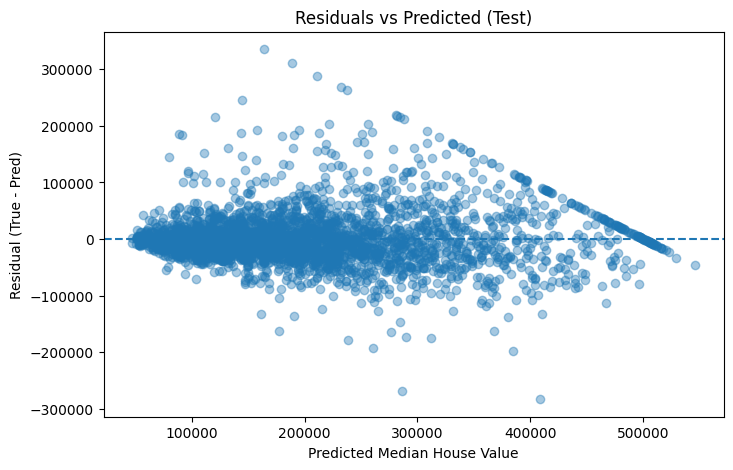

In [55]:
residuals = y_test - test_preds
plt.figure(figsize=(8,5))
plt.scatter(test_preds, residuals, alpha=0.4)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Median House Value")
plt.ylabel("Residual (True - Pred)")
plt.title("Residuals vs Predicted (Test)")
plt.show()